In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import find_peaks, savgol_filter
from scipy.fft import fft, ifft
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
def find_peaks_and_troughs(data):
    peaks, _ = find_peaks(data)
    troughs, _ = find_peaks(-data)

    if data[0] > data[1]:
        peaks = np.insert(peaks, 0, 0)
    elif data[0] < data[1]:
        troughs = np.insert(troughs, 0, 0)
    
    if data[-1] > data[-2]:
        peaks = np.append(peaks, len(data) - 1)
    elif data[-1] < data[-2]:
        troughs = np.append(troughs, len(data) - 1)

    return peaks, troughs

def filter_heart_rate(signal, sampling_rate, low_freq=0.5, high_freq=3.5):
    # Apply FFT
    freq_signal = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), d=1/sampling_rate)
    
    # # Define the normal heart rate range in Hz
    # low_freq = 0.5  # 30 BPM
    # high_freq = 3.5  # 210 BPM
    
    # Create a mask to filter frequencies outside the normal heart rate range
    mask = (freqs >= low_freq) & (freqs <= high_freq)
    
    # Apply the mask to the frequency domain signal
    filtered_freq_signal = np.zeros_like(freq_signal)
    filtered_freq_signal[mask] = freq_signal[mask]
    
    # Inverse FFT to convert back to the time domain
    filtered_signal = np.fft.ifft(filtered_freq_signal)
    
    return np.real(filtered_signal)

def frame_error(df_vol, df_class):
    patient_li = []
    EDV_error_li = []
    ESV_error_li = []
    split = []
    for patient in df_vol['Patient'].unique():
        sampling_rate = 1 / df.loc[df['Patient'] == patient, 'Time (s)'].values[1]
        time = df.loc[df['Patient'] == patient, 'Time (s)'].values
        left_ventricle_volume = df.loc[df['Patient'] == patient, 'Volume'].values
        filtered_volume = filter_heart_rate(left_ventricle_volume, sampling_rate)
        peaks, troughs = find_peaks_and_troughs(filtered_volume)
        if ''.join([patient, '.avi']) not in df_class['FileName'].values:
            continue
        EDV_peak_diff = peaks - df_class.loc[df_class['FileName'] == ''.join([patient, '.avi']), 'EDV_frame'].values
        ESV_trough_diff = troughs - df_class.loc[df_class['FileName'] == ''.join([patient, '.avi']), 'ESV_frame'].values
        patient_li.append(patient)
        EDV_error_li.append(EDV_peak_diff[np.abs(EDV_peak_diff).argmin()])
        ESV_error_li.append(ESV_trough_diff[np.abs(ESV_trough_diff).argmin()])
        split.append(df_class.loc[df_class['FileName'] == ''.join([patient, '.avi']), 'Split'].values[0])
    df_error = pd.DataFrame({'Patient': patient_li, 
                             'EDV_error': EDV_error_li, 
                             'ESV_error': ESV_error_li, 
                             'EDV_abs_error': np.abs(EDV_error_li), 
                             'ESV_abs_error': np.abs(ESV_error_li), 
                             'Split': split})
    return df_error

df = pd.read_csv(os.path.join(r'./EchoNet-Dynamic/Segmentation', 'volume_data.csv'))
df_classified = pd.read_csv(os.path.join(r'./Database', 'training_database.csv'))

df_err = frame_error(df, df_classified)

In [7]:
os.path.join('./EchoNet-Dynamic/Segmentation', 'frame_error.csv')

'./EchoNet-Dynamic/Segmentation\\frame_error.csv'

In [ ]:
df_err.to_csv(os.path.join('./EchoNet-Dynamic/Segmentation', 'frame_error.csv'), index=False)

In [15]:
df = pd.read_csv(os.path.join('EchoNet-Dynamic', 'Segmentation', 'volume_data.csv'))
df_classified = pd.read_csv(os.path.join(r'./Database', 'training_database.csv'))

C:\Users\shay2\AppData\Local\Temp\ipykernel_28576\4077541749.py:1: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join('EchoNet-Dynamic', 'Segmentation', 'volume_data.csv'))


In [16]:
df = df[df['Time (s)'] != 'Time (s)']
df['Time (s)'] = df['Time (s)'].values.astype(float)
df['Volume'] = df['Volume'].values.astype(float)
df['Frame'] = df['Frame'].values.astype(int)

In [17]:
df_err = pd.read_csv(os.path.join('EchoNet-Dynamic', 'Segmentation', 'frame_error.csv'))

In [18]:
print(df_err.shape[0])
print(df_err['Split'].value_counts())

10023
Split
TRAIN    7459
VAL      1288
TEST     1276
Name: count, dtype: int64


In [19]:
df_err['EDV_abs_error'].mean(), df_err['ESV_abs_error'].mean()

(2.191958495460441, 2.3570787189464233)

In [20]:
df_err_copy = df_err.copy()
df_err_copy.loc[df_err_copy['EDV_abs_error'] < 3, 'EDV_abs_error'] = 0
df_err_copy.loc[df_err_copy['ESV_abs_error'] < 3, 'ESV_abs_error'] = 0

In [21]:
df_err['EDV_abs_error'].max(), df_err['ESV_abs_error'].max()

(51, 81)

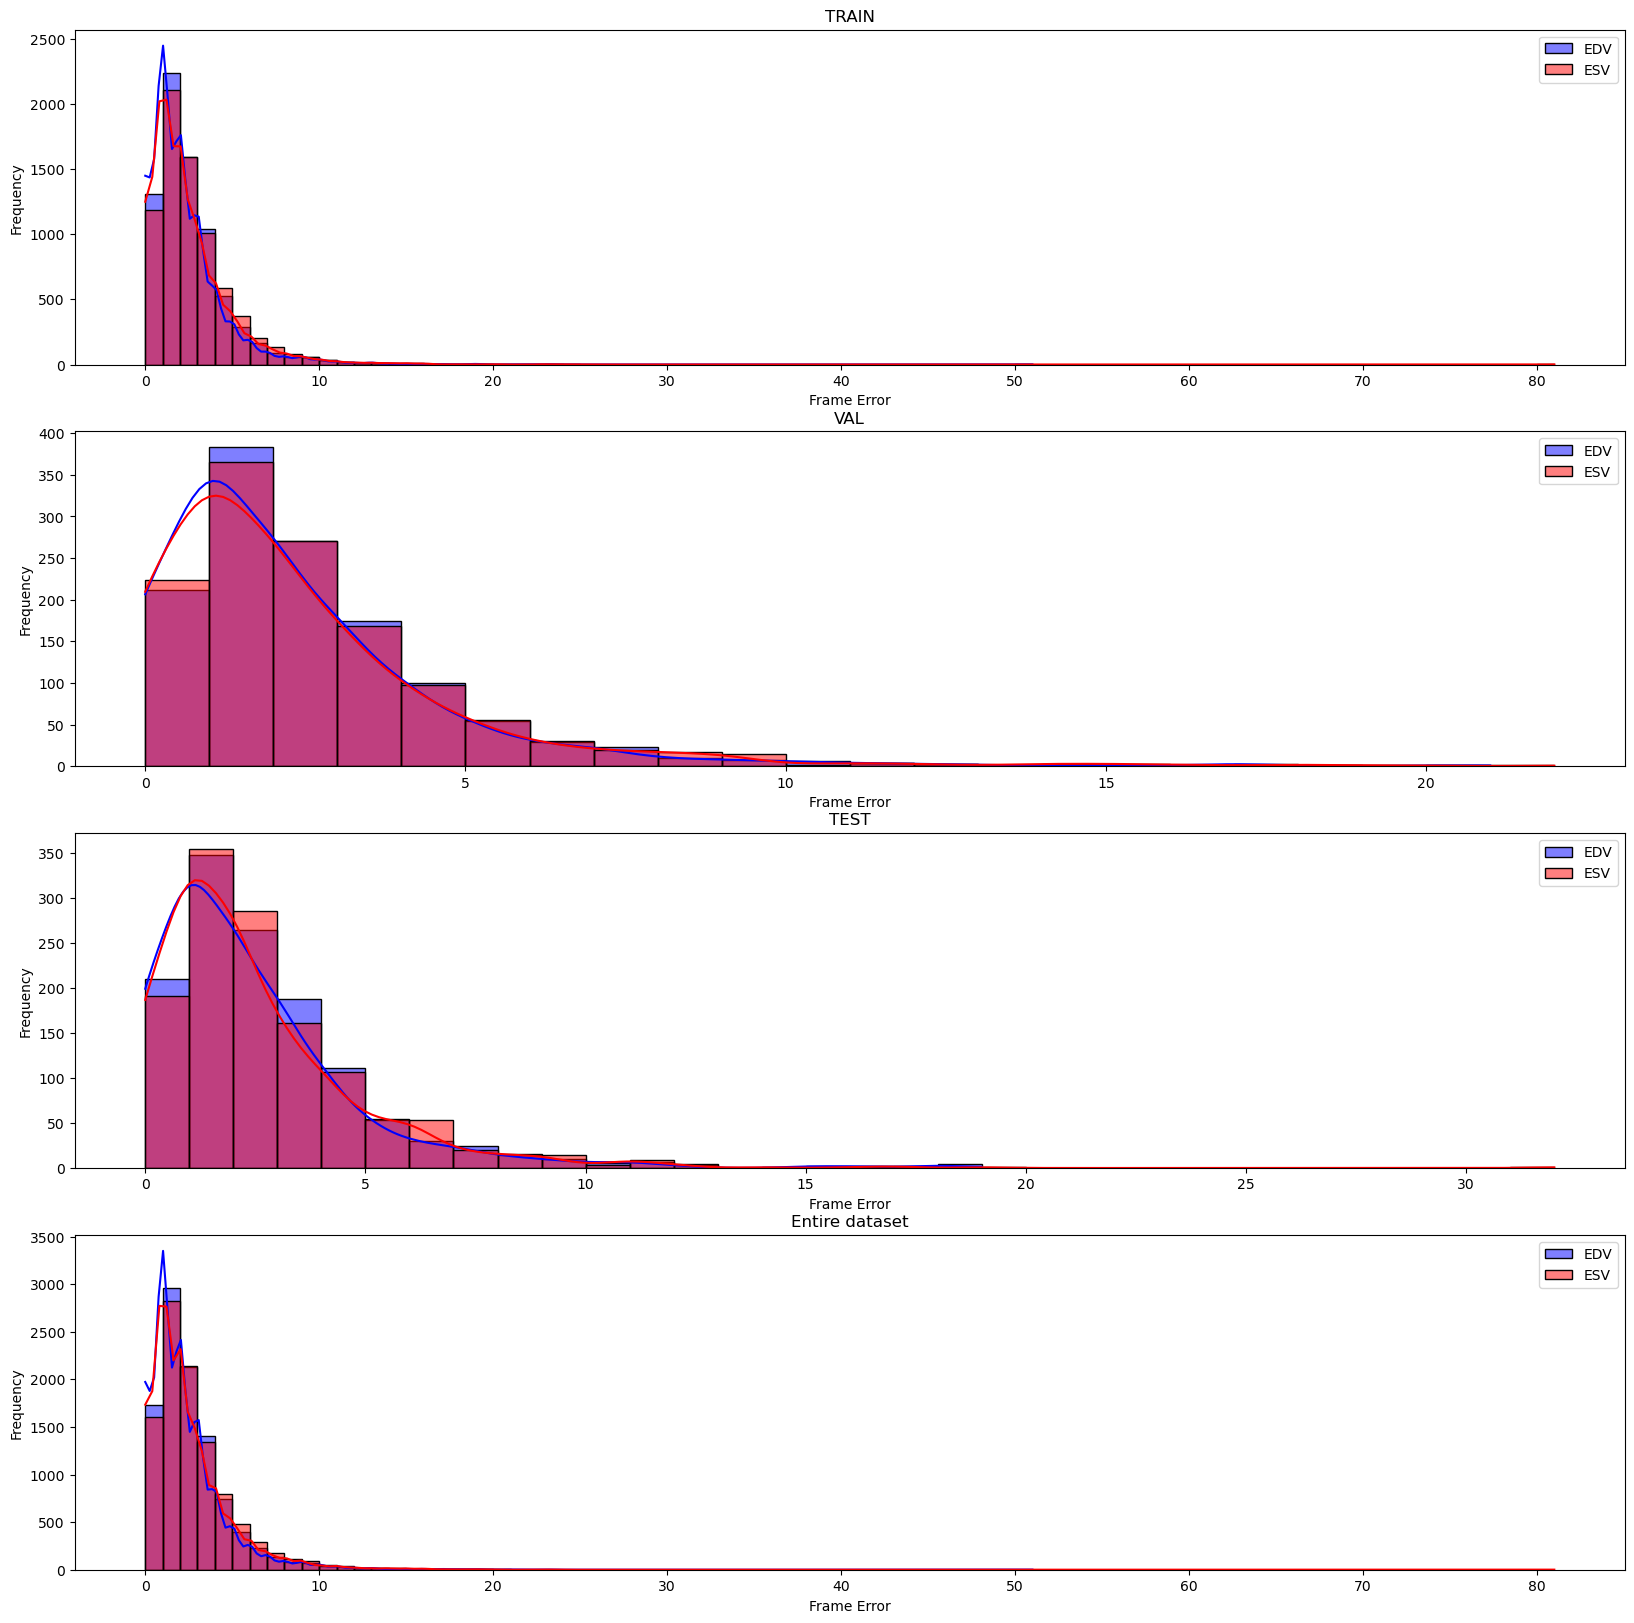

In [22]:
## Plot the error distribution subplot for each split
fig, axes = plt.subplots(4, 1, figsize=(20, 20))
sns.histplot(df_err[df_err['Split'] == 'TRAIN']['EDV_abs_error'], bins=df_err[df_err['Split'] == 'TRAIN']['EDV_abs_error'].max(), color='blue', kde=True, label='EDV', ax=axes[0])
sns.histplot(df_err[df_err['Split'] == 'TRAIN']['ESV_abs_error'], bins=df_err[df_err['Split'] == 'TRAIN']['ESV_abs_error'].max(), color='red', kde=True, label='ESV', ax=axes[0])
axes[0].set_xlabel('Frame Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title('TRAIN')
axes[0].legend()
sns.histplot(df_err[df_err['Split'] == 'VAL']['EDV_abs_error'], bins=df_err[df_err['Split'] == 'VAL']['EDV_abs_error'].max(), color='blue', kde=True, label='EDV', ax=axes[1])
sns.histplot(df_err[df_err['Split'] == 'VAL']['ESV_abs_error'], bins=df_err[df_err['Split'] == 'VAL']['ESV_abs_error'].max(), color='red', kde=True, label='ESV', ax=axes[1])
axes[1].set_xlabel('Frame Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title('VAL')
axes[1].legend()
sns.histplot(df_err[df_err['Split'] == 'TEST']['EDV_abs_error'], bins=df_err[df_err['Split'] == 'TEST']['EDV_abs_error'].max(), color='blue', kde=True, label='EDV', ax=axes[2])
sns.histplot(df_err[df_err['Split'] == 'TEST']['ESV_abs_error'], bins=df_err[df_err['Split'] == 'TEST']['ESV_abs_error'].max(), color='red', kde=True, label='ESV', ax=axes[2])
axes[2].set_xlabel('Frame Error')
axes[2].set_ylabel('Frequency')
axes[2].set_title('TEST')
axes[2].legend()
sns.histplot(df_err['EDV_abs_error'], bins=df_err['EDV_abs_error'].max(), color='blue', kde=True, label='EDV', ax=axes[3])
sns.histplot(df_err['ESV_abs_error'], bins=df_err['ESV_abs_error'].max(), color='red', kde=True, label='ESV', ax=axes[3])
axes[3].set_xlabel('Frame Error')
axes[3].set_ylabel('Frequency')
axes[3].set_title('Entire dataset')
axes[3].legend()
plt.show()

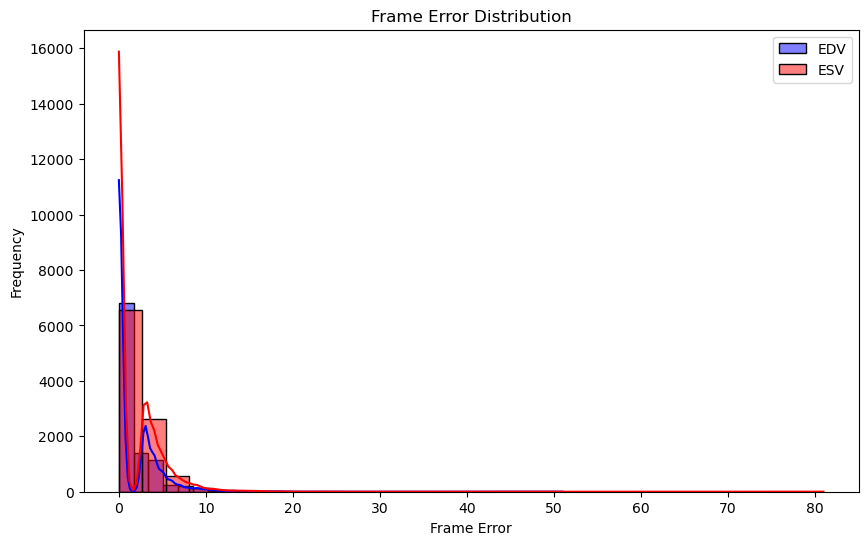

In [23]:
## Plot the error distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_err_copy['EDV_abs_error'], bins=30, color='blue', kde=True, label='EDV')
sns.histplot(df_err_copy['ESV_abs_error'], bins=30, color='red', kde=True, label='ESV')
plt.xlabel('Frame Error')
plt.ylabel('Frequency')
plt.title('Frame Error Distribution')
plt.legend()
plt.show()

In [11]:
df_err_copy['EDV_abs_error'].mean(), df_err_copy['ESV_abs_error'].mean()

(1.4723136785393596, 1.6473111842761647)

In [12]:
EDV_acc = df_err_copy[df_err_copy['EDV_abs_error'] == 0].shape[0] / df_err_copy.shape[0]
ESV_acc = df_err_copy[df_err_copy['ESV_abs_error'] == 0].shape[0] / df_err_copy.shape[0]
print(f'EDV accuracy: {EDV_acc * 100:.2f}%')
print(f'ESV accuracy: {ESV_acc * 100:.2f}%')

EDV accuracy: 67.99%
ESV accuracy: 65.57%


In [198]:
df_err_copy['EDV_abs_error'].value_counts(normalize=True).sort_index().cumsum()

EDV_abs_error
0     0.679936
3     0.820014
4     0.893744
5     0.933353
6     0.955901
7     0.969171
8     0.977053
9     0.984436
10    0.989125
11    0.992318
12    0.994114
13    0.995610
14    0.996209
15    0.996907
16    0.997606
17    0.998304
18    0.998803
19    0.999302
20    0.999401
21    0.999601
22    0.999701
23    0.999900
51    1.000000
Name: proportion, dtype: float64

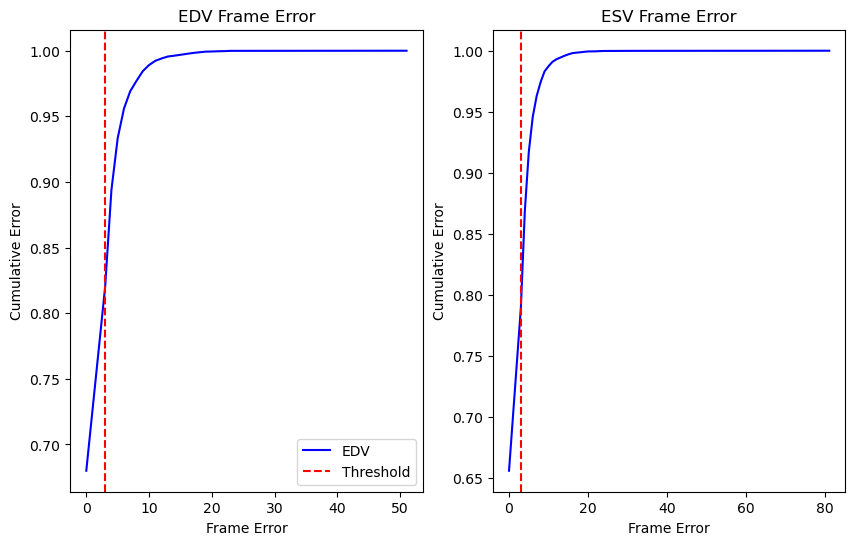

In [200]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
edv_data = df_err_copy['EDV_abs_error'].value_counts(normalize=True).sort_index().cumsum()
esv_data = df_err_copy['ESV_abs_error'].value_counts(normalize=True).sort_index().cumsum()
ax[0].plot(edv_data.index, edv_data.values, color='blue', label='EDV')
ax[0].set_xlabel('Frame Error')
ax[0].set_ylabel('Cumulative Error')
ax[0].set_title('EDV Frame Error')
ax[0].axvline(3, color='red', linestyle='--', label='Threshold')
ax[0].legend()
ax[1].plot(esv_data.index, esv_data.values, color='blue', label='ESV')
ax[1].set_xlabel('Frame Error')
ax[1].set_ylabel('Cumulative Error')
ax[1].axvline(3, color='red', linestyle='--', label='Threshold')
ax[1].set_title('ESV Frame Error')
plt.show()

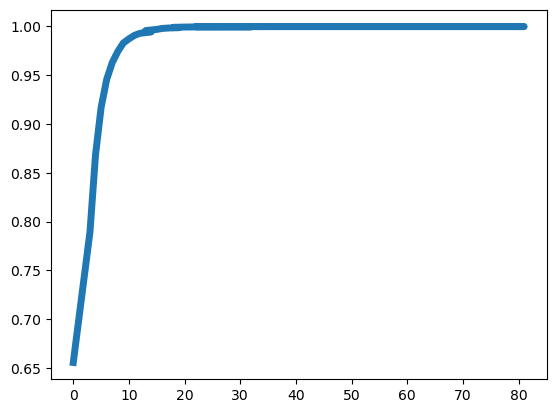

In [186]:
data = df_err_copy['ESV_abs_error'].value_counts(normalize=True).cumsum()
plt.plot(data.index, data.values, linewidth=5)
plt.show()

In [14]:
df_err_copy['ESV_abs_error'].value_counts(normalize=True).cumsum()

ESV_abs_error
0     0.655692
3     0.789484
4     0.868702
5     0.916991
6     0.945725
7     0.962985
8     0.974359
9     0.983139
10    0.987329
11    0.990921
12    0.993016
14    0.994413
13    0.995810
15    0.997007
16    0.998005
17    0.998404
19    0.998803
18    0.999102
20    0.999401
23    0.999601
32    0.999701
22    0.999800
81    0.999900
24    1.000000
Name: proportion, dtype: float64

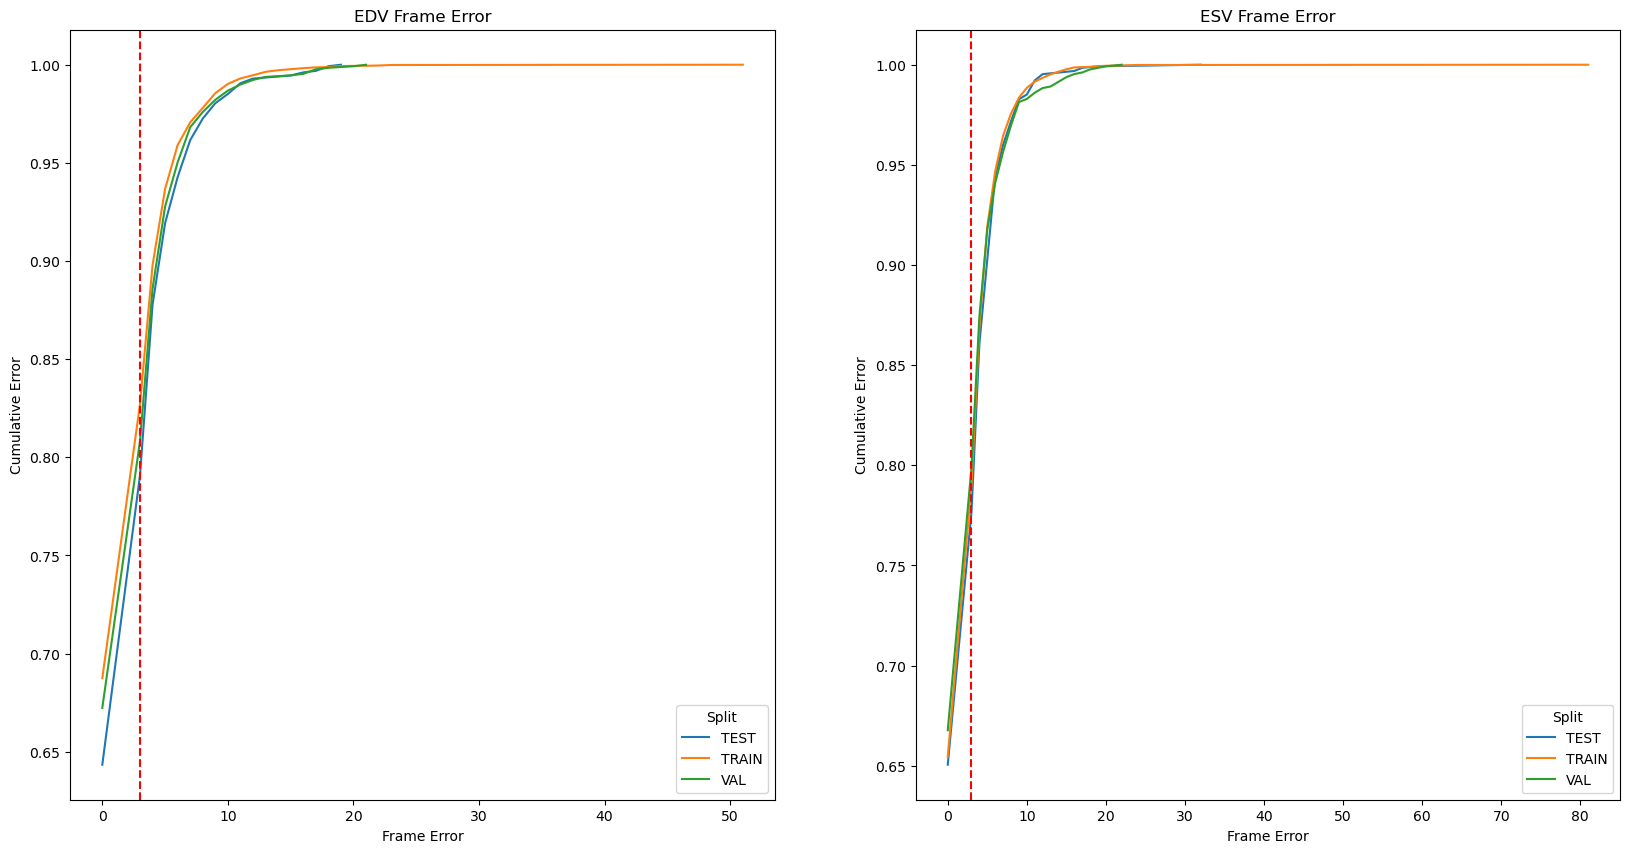

In [203]:
import seaborn as sns

EDV_data = df_err_copy.groupby('Split')['EDV_abs_error'].value_counts(normalize=True).sort_index().groupby(level=0).cumsum().reset_index(name='cumsum')
ESV_data = df_err_copy.groupby('Split')['ESV_abs_error'].value_counts(normalize=True).sort_index().groupby(level=0).cumsum().reset_index(name='cumsum')
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(data=EDV_data, x='EDV_abs_error', y='cumsum', hue='Split', ax=axes[0])
axes[0].set_xlabel('Frame Error')
axes[0].set_ylabel('Cumulative Error')
axes[0].set_title('EDV Frame Error')
axes[0].axvline(3, color='red', linestyle='--', label='Threshold')
sns.lineplot(data=ESV_data, x='ESV_abs_error', y='cumsum', hue='Split', ax=axes[1])
axes[1].set_xlabel('Frame Error')
axes[1].set_ylabel('Cumulative Error')
axes[1].set_title('ESV Frame Error')
axes[1].axvline(3, color='red', linestyle='--', label='Threshold')
plt.show()

In [204]:
df_err_copy.groupby('Split')['ESV_abs_error'].value_counts(normalize=True).sort_index().groupby(level=0).cumsum()

Split  ESV_abs_error
TEST   0                0.650470
       3                0.776646
       4                0.860502
       5                0.902821
       6                0.944357
       7                0.960031
       8                0.971787
       9                0.982759
       10               0.985110
       11               0.992163
       12               0.995298
       14               0.996082
       16               0.996865
       17               0.998433
       19               0.999216
       32               1.000000
TRAIN  0                0.654511
       3                0.790052
       4                0.869151
       5                0.919292
       6                0.946776
       7                0.964607
       8                0.975600
       9                0.983510
       10               0.988470
       11               0.991554
       12               0.993431
       13               0.995174
       14               0.996514
       15             

In [206]:
df_err_copy.groupby('Split')['EDV_abs_error'].value_counts(normalize=True).sort_index().groupby(level=0).cumsum()

Split  EDV_abs_error
TEST   0                0.643417
       3                0.790752
       4                0.877743
       5                0.919279
       6                0.942790
       7                0.961599
       8                0.972571
       9                0.980408
       10               0.985110
       11               0.990596
       12               0.992947
       15               0.994514
       16               0.996082
       17               0.996865
       18               0.999216
       19               1.000000
TRAIN  0                0.687492
       3                0.827055
       4                0.897842
       5                0.936721
       6                0.959110
       7                0.970639
       8                0.978013
       9                0.985521
       10               0.990213
       11               0.993029
       12               0.994637
       13               0.996380
       14               0.997185
       15             

In [26]:
df = df.drop_duplicates(subset=['Patient', 'Frame', 'Time (s)', 'Volume'])

In [27]:
def find_peaks_and_troughs(data):
    peaks, _ = find_peaks(data)
    troughs, _ = find_peaks(-data)

    if data[0] > data[1]:
        peaks = np.insert(peaks, 0, 0)
    elif data[0] < data[1]:
        troughs = np.insert(troughs, 0, 0)
    
    if data[-1] > data[-2]:
        peaks = np.append(peaks, len(data) - 1)
    elif data[-1] < data[-2]:
        troughs = np.append(troughs, len(data) - 1)

    return peaks, troughs

def filter_heart_rate(signal, sampling_rate, low_freq=0.5, high_freq=3.5):
    # Apply FFT
    freq_signal = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), d=1/sampling_rate)
    
    # Create a mask to filter frequencies outside the normal heart rate range
    mask = (freqs >= low_freq) & (freqs <= high_freq)
    
    # Apply the mask to the frequency domain signal
    filtered_freq_signal = np.zeros_like(freq_signal)
    filtered_freq_signal[mask] = freq_signal[mask]
    
    # Inverse FFT to convert back to the time domain
    filtered_signal = np.fft.ifft(filtered_freq_signal)
    
    return np.real(filtered_signal)

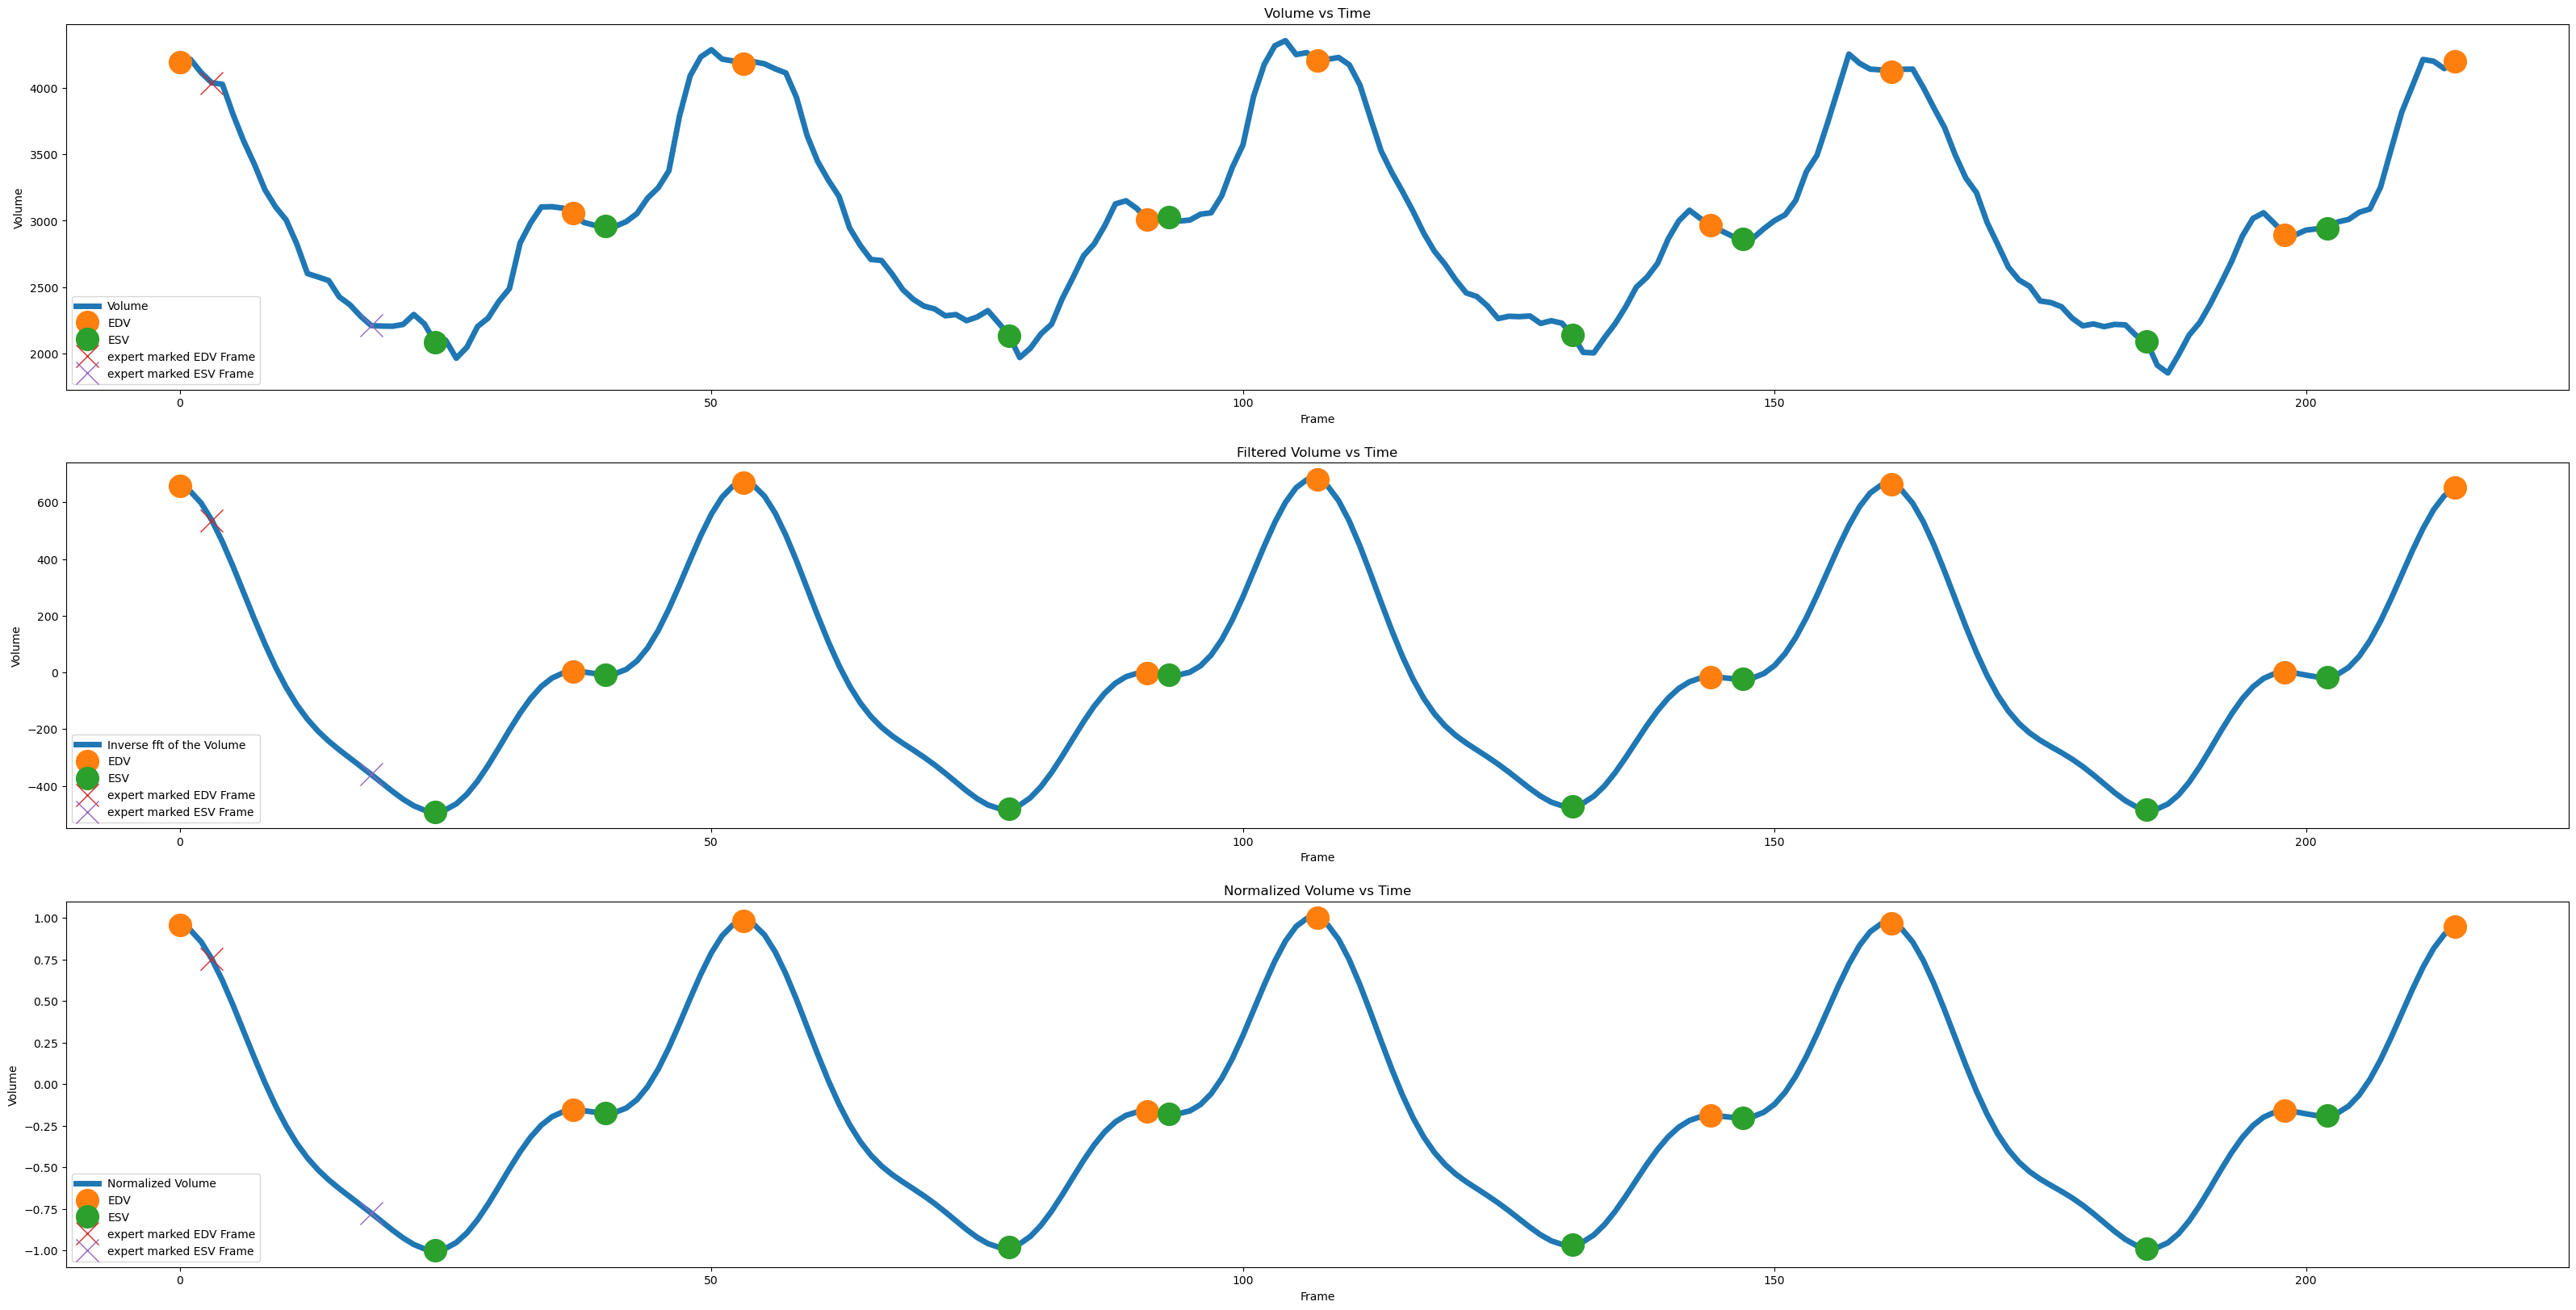

EDV frame error: 3
ESV frame error: 6


In [28]:
# patient = '0X5FD81C7210683832' ## wrong label by expert for EDV
# patient = '0X54E4998C51F9E270' ## tricky volume curve
# patient = '0X6D3B3F63E5A98B19'
# patient = '0X24DEA0FED8614873'
# patient = '0X30A216CE9B22EF5'
# patient = '0X7F3F1029C810EC0C'
# patient = '0X999693BACC06F2A'
patient = '0X1002E8FBACD08477' # 3 EDV error, 6 ESV error
# patient = '0X7026A611CB19B457'
# patient = '0X208FBB50F39AAF69' # 23 EDV error, 0 ESV error
# patient = '0X20B431A11992F8C1' # 3 EDV error, 3 ESV error
# patient = '0X20BF40D7DF972197' # 3 EDV error, 5 ESV error
# patient = '0XD5ED87EECABCE2F'


marker_size = 20
if type(df.loc[df['Patient'] == patient, 'Time (s)'].values[1]) != float:
    df = df[df['Time (s)'] != 'Time (s)']
    df['Time (s)'] = df['Time (s)'].values.astype(float)
    df['Volume'] = df['Volume'].values.astype(float)
    df['Frame'] = df['Frame'].values.astype(int)
    sampling_rate = 1 / float(df.loc[df['Patient'] == patient, 'Time (s)'].values[1])
else:
    sampling_rate = 1 / df.loc[df['Patient'] == patient, 'Time (s)'].values[1]
time = df.loc[df['Patient'] == patient, 'Time (s)'].values
frames = df.loc[df['Patient'] == patient, 'Frame'].values
left_ventricle_volume = df.loc[df['Patient'] == patient, 'Volume'].values
filtered_volume = filter_heart_rate(left_ventricle_volume, sampling_rate)
peaks, troughs = find_peaks_and_troughs(filtered_volume)
normalized_volume = MinMaxScaler(feature_range=(-1, 1)).fit_transform(filtered_volume.reshape(-1, 1)).flatten()
fig, axes = plt.subplots(3, 1, figsize=(40, 20))
axes[0].plot(frames, left_ventricle_volume, label='Volume', linewidth=5)
axes[0].plot(peaks, left_ventricle_volume[peaks], 'o', label='EDV', markersize=marker_size)
axes[0].plot(troughs, left_ventricle_volume[troughs], 'o', label='ESV', markersize=marker_size)
EDV_frame = df_classified.loc[df_classified['FileName'] == ''.join([patient, '.avi']), 'EDV_frame'].values
ESV_frame = df_classified.loc[df_classified['FileName'] == ''.join([patient, '.avi']), 'ESV_frame'].values
axes[0].plot(EDV_frame, left_ventricle_volume[EDV_frame], 'x', label='expert marked EDV Frame', markersize=marker_size)
axes[0].plot(ESV_frame, left_ventricle_volume[ESV_frame], 'x', label='expert marked ESV Frame', markersize=marker_size)
axes[0].set_xlabel('Frame')
axes[0].set_ylabel('Volume')
axes[0].set_title('Volume vs Time')
axes[0].legend()
axes[1].plot(frames, filtered_volume, label='Inverse fft of the Volume', linewidth=5)
axes[1].plot(peaks, filtered_volume[peaks], 'o', label='EDV', markersize=marker_size)
axes[1].plot(troughs, filtered_volume[troughs], 'o', label='ESV', markersize=marker_size)
axes[1].plot(EDV_frame, filtered_volume[EDV_frame], 'x', label='expert marked EDV Frame', markersize=marker_size)
axes[1].plot(ESV_frame, filtered_volume[ESV_frame], 'x', label='expert marked ESV Frame', markersize=marker_size)
axes[1].set_xlabel('Frame')
axes[1].set_ylabel('Volume')
axes[1].set_title('Filtered Volume vs Time')
axes[1].legend()
axes[2].plot(frames, normalized_volume, label='Normalized Volume', linewidth=5)
axes[2].plot(peaks, normalized_volume[peaks], 'o', label='EDV', markersize=marker_size)
axes[2].plot(troughs, normalized_volume[troughs], 'o', label='ESV', markersize=marker_size)
axes[2].plot(EDV_frame, normalized_volume[EDV_frame], 'x', label='expert marked EDV Frame', markersize=marker_size)
axes[2].plot(ESV_frame, normalized_volume[ESV_frame], 'x', label='expert marked ESV Frame', markersize=marker_size)
axes[2].set_xlabel('Frame')
axes[2].set_ylabel('Volume')
axes[2].set_title('Normalized Volume vs Time')
axes[2].legend()
plt.show()
print(f'EDV frame error: {np.abs((peaks - EDV_frame).min())}')
print(f'ESV frame error: {np.abs((troughs - ESV_frame).min())}')

In [ ]:
plt.plot(frames, filtered_volume, label='Inverse fft of the Volume', linewidth=5)
plt.plot(peaks, filtered_volume[peaks], 'o', label='EDV', markersize=marker_size)
plt.plot(troughs, filtered_volume[troughs], 'o', label='ESV', markersize=marker_size)
plt.plot(EDV_frame, filtered_volume[EDV_frame], 'x', label='expert marked EDV Frame', markersize=marker_size)
plt.plot(ESV_frame, filtered_volume[ESV_frame], 'x', label='expert marked ESV Frame', markersize=marker_size)
plt.set_xlabel('Frame')
plt.set_ylabel('Volume')
plt.set_title('Filtered Volume vs Time')
plt.legend()

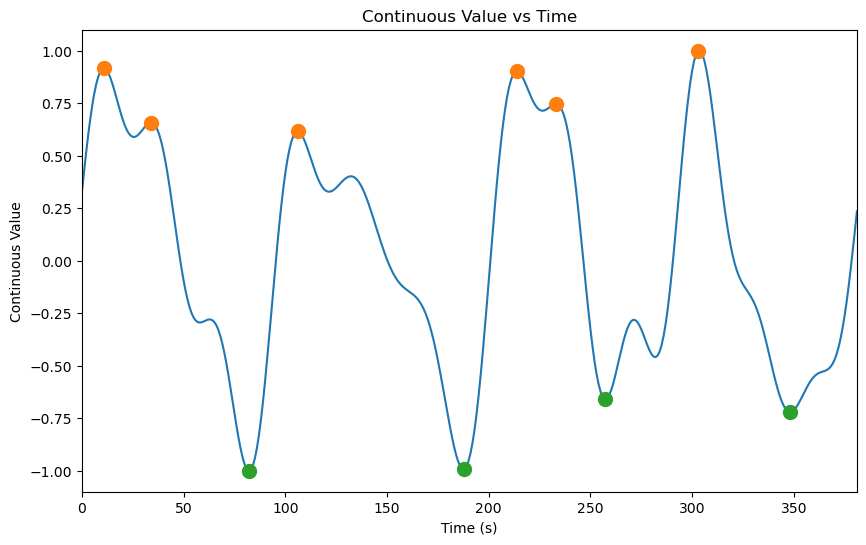

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(frames, normalized_volume, label='Normalized Volume')
plt.plot(peaks[normalized_volume[peaks] > 0.5], normalized_volume[peaks[normalized_volume[peaks] > 0.5]], 'o', label='EDV', markersize=marker_size)
plt.plot(troughs[normalized_volume[troughs] < -0.5], normalized_volume[troughs[normalized_volume[troughs] < -0.5]], 'o', label='EDV', markersize=marker_size)
# plt.plot(EDV_frame, normalized_volume[EDV_frame], 'x', label='expert marked EDV Frame', markersize=marker_size)
# plt.plot(ESV_frame, normalized_volume[ESV_frame], 'x', label='expert marked ESV Frame', markersize=marker_size)
plt.gca().set_xlabel('Time (s)')
plt.gca().set_ylabel('Continuous Value')
plt.gca().set_xlim(frames[0], frames[-1])
plt.gca().set_ylim(-1.1, 1.1)
plt.gca().set_title('Continuous Value vs Time')
# plt.legend()
plt.show()

In [160]:
# import matplotlib.animation as animation

# fig, ax = plt.subplots(figsize=(10, 6))

# def animate(i):
#     ax.clear()
#     ax.plot(frames[:i], normalized_volume[:i])
#     ax.set_xlabel('Frame Number')
#     ax.set_ylabel('Continuous Value')
#     ax.set_xlim(frames[0], frames[-1])
#     ax.set_ylim(-1.1, 1.1)
#     ax.set_title('Continuous Value vs Time')

# # Create animation
# ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=20)  # 20ms per frame for 50fps

# # Save the animation
# ani.save('animation.gif', writer='pillow', fps=50)

# # Show the plot (optional)
# plt.show()

In [161]:
type(expert_edv_frame_img)

numpy.ndarray

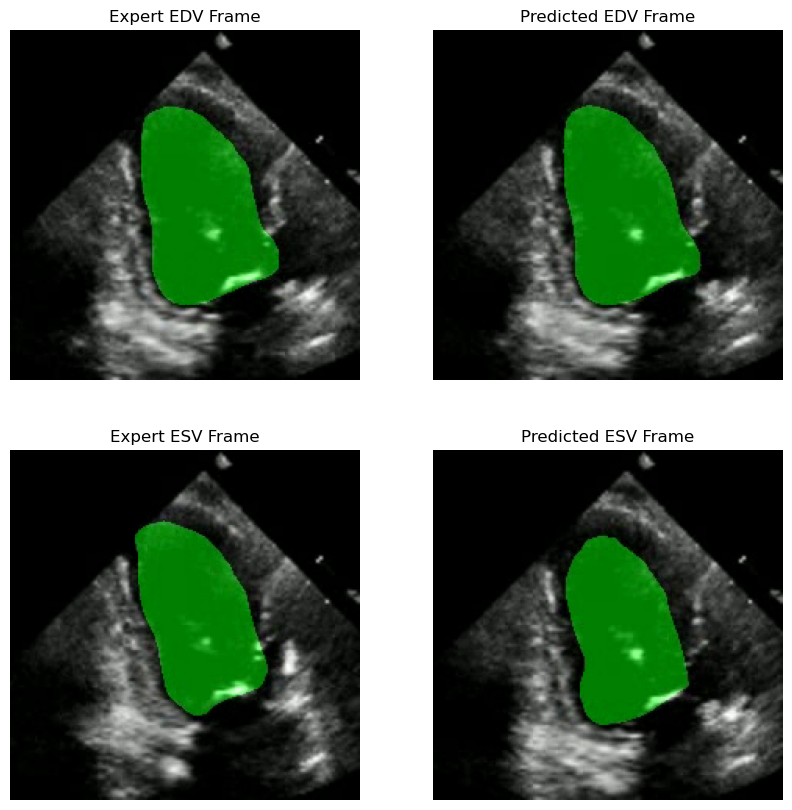

In [162]:
import cv2
import os
from torchvision.transforms import ToPILImage, ToTensor
from torch.nn.functional import sigmoid
import matplotlib.pyplot as plt
from Scripts import data_transforms
from Scripts.models import transunet
import torch

def resize_frame(frame, size=(224, 224)):
    pil_image = ToPILImage()(frame)
    resized_image = pil_image.resize(size)
    resized_image = resized_image.convert('L')
    return resized_image 

# Function to capture a frame from a video
def capture_frame(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    success, frame = cap.read()
    if success:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        return None

import numpy as np

def get_prediction_with_threshold_with_alpha(image, threshold=0.9):
    # Apply the model to the image
    image = ToPILImage()(image.float().squeeze(0))
    model_output = sigmoid(model(data_transforms.video_transform(image).unsqueeze(0)))
    
    # Apply the threshold to get the segmentation mask
    segmentation_mask = model_output > threshold
    
    # Initialize an RGBA image with zeros (fully transparent)
    segmentation_mask_rgba = np.zeros((*segmentation_mask.squeeze(0).squeeze(0).shape, 4), dtype=np.float32)
    
    # Set the green channel to 1 (or 255 for 8-bit images) where the mask is true
    segmentation_mask_rgba[segmentation_mask.squeeze(0).squeeze(0), 1] = 1  # Use 255 instead of 1 if you're working with 8-bit images
    
    # Set the alpha channel to 0.8 where the mask is true, 0 everywhere else
    segmentation_mask_rgba[segmentation_mask.squeeze(0).squeeze(0), 3] = 0.8
    
    return segmentation_mask_rgba

threshold = 0.9

# model = transunet.TransUNet112(img_size=224, patch_size=8, num_classes=1, in_channels=1)
# model.load_state_dict(torch.load(os.path.join('models', 'transunet_6epochs.pth')))

# videos_path = os.path.join('EchoNet-Dynamic', 'Videos')
# patient_video_path = os.path.join(videos_path, ''.join([patient, '.avi']))

videos_path = os.path.join('EchoNet-Dynamic', 'Segmentation')
patient_video_path = os.path.join(videos_path, ''.join(['output_', patient, '.mp4']))

cap = cv2.VideoCapture(patient_video_path)

# Assuming EDV_frame and ESV_frame are the frame numbers for EDV and ESV
EDV_frame_number = EDV_frame[0]  # Replace EDV_frame with the actual frame number
ESV_frame_number = ESV_frame[0]  # Replace ESV_frame with the actual frame number



# Capture the EDV and ESV frames
expert_edv_frame_img = capture_frame(patient_video_path, EDV_frame_number)
expert_esv_frame_img = capture_frame(patient_video_path, ESV_frame_number)
predicted_edv_frame_img = capture_frame(patient_video_path, filtered_volume[peaks].argmin())
predicted_esv_frame_img = capture_frame(patient_video_path, filtered_volume[troughs].argmin())
# seg_expert_edv_frame_img = get_prediction_with_threshold_with_alpha(data_transforms.video_transform(resize_frame(expert_edv_frame_img)).unsqueeze(0), threshold=threshold)
# seg_expert_esv_frame_img = get_prediction_with_threshold_with_alpha(data_transforms.video_transform(resize_frame(expert_esv_frame_img)).unsqueeze(0), threshold=threshold)
# seg_pred_edv_frame_img = get_prediction_with_threshold_with_alpha(data_transforms.video_transform(resize_frame(predicted_edv_frame_img)).unsqueeze(0), threshold=threshold)
# seg_pred_esv_frame_img = get_prediction_with_threshold_with_alpha(data_transforms.video_transform(resize_frame(predicted_esv_frame_img)).unsqueeze(0), threshold=threshold)


# Plot the frames
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(expert_edv_frame_img)
axes[0, 0].set_title('Expert EDV Frame')
axes[0, 0].axis('off')

axes[0, 1].imshow(predicted_edv_frame_img)
axes[0, 1].set_title('Predicted EDV Frame')
axes[0, 1].axis('off')

axes[1, 0].imshow(expert_esv_frame_img)
axes[1, 0].set_title('Expert ESV Frame')
axes[1, 0].axis('off')

axes[1, 1].imshow(predicted_esv_frame_img)
axes[1, 1].set_title('Predicted ESV Frame')
axes[1, 1].axis('off')

plt.show()